C:\Users\PLN\AppData\Local\Temp\ipykernel_8580\126076512.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill').fillna(0)


Using device: cuda


C:\Users\PLN\AppData\Local\Temp\ipykernel_8580\126076512.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('dstgrnn_model.pth', map_loca

Loaded model weights from dstgrnn_model.pth
Epoch 1/12 - Train Loss: 17.749401 - Val Loss: 41.820611
Epoch 2/12 - Train Loss: 18.136213 - Val Loss: 51.090444
Epoch 3/12 - Train Loss: 17.865645 - Val Loss: 37.939441
Epoch 4/12 - Train Loss: 17.522665 - Val Loss: 42.922915
Epoch 5/12 - Train Loss: 17.593162 - Val Loss: 44.797653
Epoch 6/12 - Train Loss: 17.615195 - Val Loss: 41.910756
Epoch 7/12 - Train Loss: 17.701694 - Val Loss: 47.346309
Epoch 8/12 - Train Loss: 19.954996 - Val Loss: 57.428154
Epoch 9/12 - Train Loss: 18.173186 - Val Loss: 43.494347
Epoch 10/12 - Train Loss: 18.033656 - Val Loss: 49.536029
Epoch 11/12 - Train Loss: 18.658042 - Val Loss: 41.475413
Epoch 12/12 - Train Loss: 18.043659 - Val Loss: 42.413671
Loaded best model state from validation.
Test Loss: 60.020806


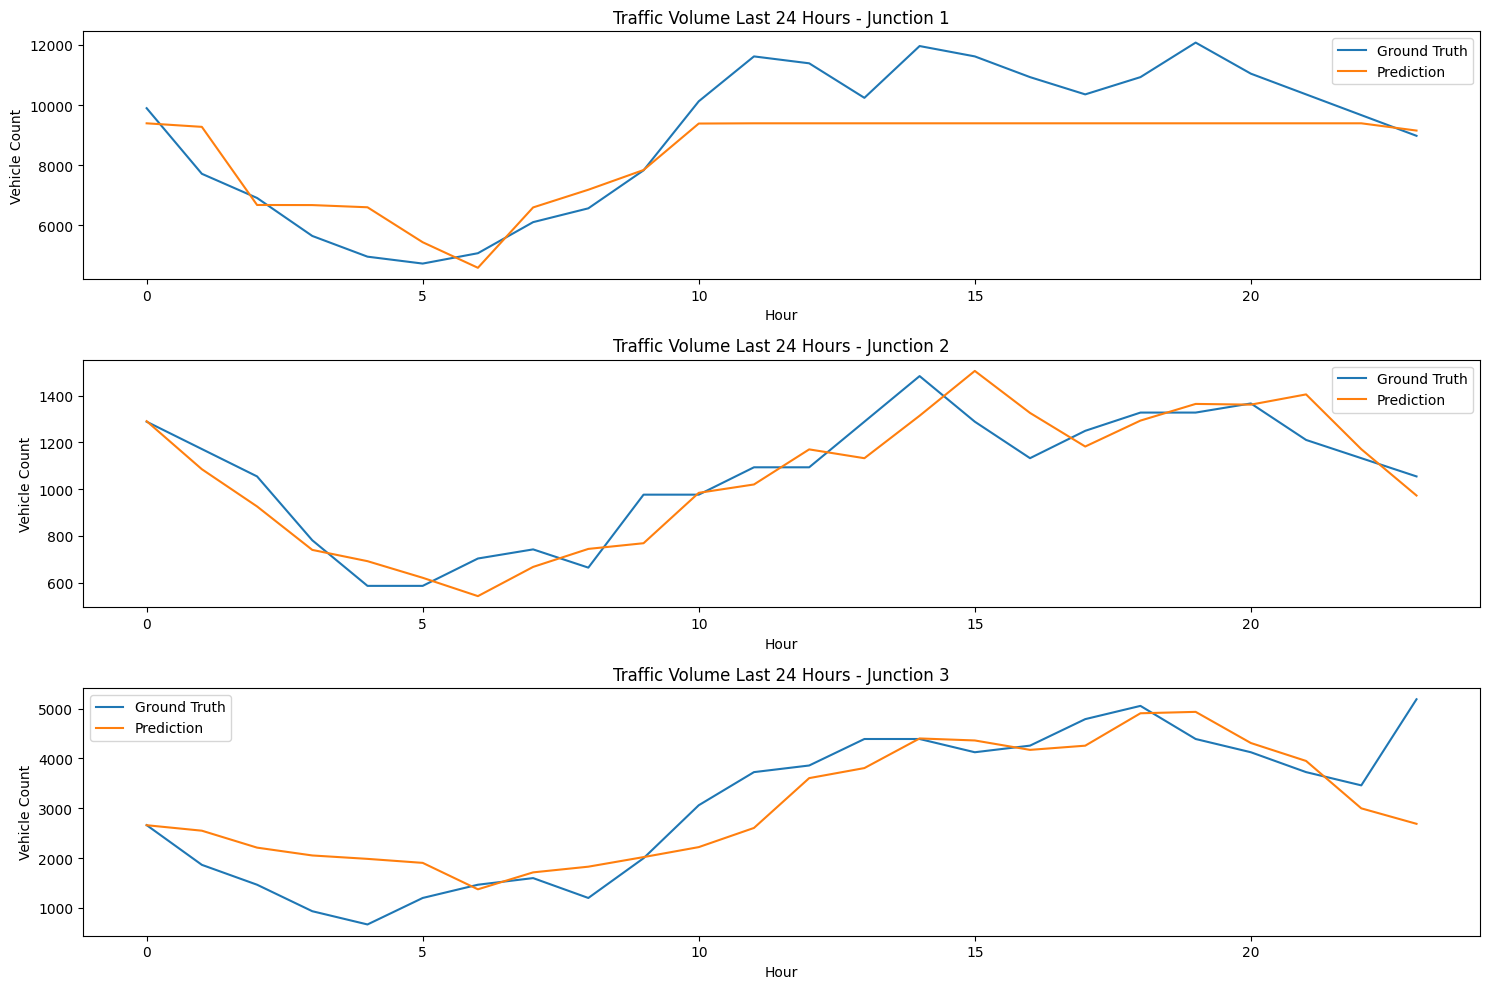

Junction           RMSE        MAE         R2
Junction 1      1389.60    1154.14       0.67
Junction 2       115.67      94.75       0.80
Junction 3       777.65     548.43       0.71
Model saved as dstgrnn_model_next.pth


In [24]:
# --- Load data and prepare datasets as in GNN_test_order_DSTGRNN.ipynb ---
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import matplotlib.pyplot as plt

# 1. Load and preprocess data (same as before)
df = pd.read_csv('traffic.csv')
df = df[df['Junction'].isin([1,2,3])]
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df_pivot = df.pivot(index='DateTime', columns='Junction', values='Vehicles')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill').fillna(0)
data = df_pivot.values

n_samples = data.shape[0]
train_size_idx = int(n_samples * 0.7)
val_size_idx = int(n_samples * 0.1)
test_size_idx = n_samples - train_size_idx - val_size_idx

train_data_unscaled = data[:train_size_idx]
val_data_unscaled = data[train_size_idx : train_size_idx + val_size_idx]
test_data_unscaled = data[train_size_idx + val_size_idx :]

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_unscaled)
val_data_scaled = scaler.transform(val_data_unscaled)
test_data_scaled = scaler.transform(test_data_unscaled)

def create_temporal_graph_dataset(data, lags=24, horizon=1):
    num_samples = data.shape[0] - lags - horizon + 1
    features_list = []
    targets_list = []
    for i in range(num_samples):
        features = data[i : i + lags]
        target = data[i + lags : i + lags + horizon]
        features_list.append(features.T.astype(np.float32))
        targets_list.append(target.T.astype(np.float32))
    return features_list, targets_list

lags = 24
horizon = 1
features, targets = create_temporal_graph_dataset(data, lags=lags, horizon=horizon)
features = np.array(features)
targets = np.array(targets)

n_total = data.shape[0] - lags - horizon + 1
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

X_train, y_train = features[:n_train], targets[:n_train]
X_val, y_val = features[n_train:n_train+n_val], targets[n_train:n_train+n_val]
X_test, y_test = features[n_train+n_val:], targets[n_train+n_val:]

def build_pyg_temporal_dataset(X, y):
    dataset = []
    for i in range(X.shape[0]):
        dataset.append(
            StaticGraphTemporalSignal(
                edge_index=None,  # Not used in DSTGRNN
                edge_weight=None,
                features=[X[i]],
                targets=[y[i]]
            )
        )
    return dataset

train_dataset = build_pyg_temporal_dataset(X_train, y_train)
val_dataset = build_pyg_temporal_dataset(X_val, y_val)
test_dataset = build_pyg_temporal_dataset(X_test, y_test)

# --- Model definition (same as in GNN_test_order_DSTGRNN.ipynb) ---
import torch.nn as nn

class DSTGRNNCell(nn.Module):
    def __init__(self, node_features, hidden_dim, num_nodes):
        super().__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.num_nodes = num_nodes
        self.adj_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )
        self.gru = nn.GRUCell(node_features + hidden_dim, hidden_dim)
    def forward(self, x, h):
        adj_logits = self.adj_mlp(h)
        adj = torch.sigmoid(adj_logits)
        adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)
        agg = torch.matmul(adj, h)
        gru_input = torch.cat([x, agg], dim=-1)
        h_new = self.gru(gru_input, h)
        return h_new, adj

class DSTGRNN(nn.Module):
    def __init__(self, node_features, hidden_dim, num_nodes, out_dim=1):
        super().__init__()
        self.cell = DSTGRNNCell(node_features, hidden_dim, num_nodes)
        self.linear = nn.Linear(hidden_dim, out_dim)
    def forward(self, x_seq):
        num_nodes, lags, node_features = x_seq.shape
        h = torch.zeros(num_nodes, self.cell.hidden_dim, device=x_seq.device)
        for t in range(lags):
            x_t = x_seq[:, t, :]
            h, adj = self.cell(x_t, h)
        out = self.linear(F.relu(h))
        return out

class RecurrentGNN(torch.nn.Module):
    def __init__(self, node_features=1, filters=32, num_nodes=3):
        super().__init__()
        self.recurrent = DSTGRNN(node_features, filters, num_nodes)
    def forward(self, x_seq):
        return self.recurrent(x_seq)

# --- Load model and optimizer ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = RecurrentGNN(node_features=1, filters=32, num_nodes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# --- Load previous weights ---
model.load_state_dict(torch.load('dstgrnn_model.pth', map_location=device))
print("Loaded model weights from dstgrnn_model.pth")

# --- Continue training ---
epochs = 12
patience = 12
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

def batchify(dataset, batch_size):
    return [dataset[i:i+batch_size] for i in range(0, len(dataset), batch_size)]

batch_size = 64
batched_train = batchify(train_dataset, batch_size)
batched_val = batchify(val_dataset, batch_size)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    num_train_snapshots = 0
    for batch in batched_train:
        optimizer.zero_grad()
        x_seqs = torch.stack([torch.tensor(s.features[0], dtype=torch.float32, device=device).unsqueeze(-1) for s in batch])
        y_trues = torch.stack([torch.tensor(s.targets[0], dtype=torch.float32, device=device).squeeze(-1) for s in batch])
        batch_loss = 0
        for i in range(x_seqs.shape[0]):
            x_seq = x_seqs[i].permute(0, 1, 2)
            y_true = y_trues[i]
            y_pred = model(x_seq).squeeze(-1)
            batch_loss += criterion(y_pred, y_true)
        batch_loss = batch_loss / x_seqs.shape[0]
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item() * x_seqs.shape[0]
        num_train_snapshots += x_seqs.shape[0]
    avg_train_loss = total_loss / num_train_snapshots if num_train_snapshots > 0 else 0

    # Validation
    model.eval()
    val_loss = 0
    num_val_snapshots = 0
    with torch.no_grad():
        for batch in batched_val:
            x_seqs = torch.stack([torch.tensor(s.features[0], dtype=torch.float32, device=device).unsqueeze(-1) for s in batch])
            y_trues = torch.stack([torch.tensor(s.targets[0], dtype=torch.float32, device=device).squeeze(-1) for s in batch])
            batch_loss = 0
            for i in range(x_seqs.shape[0]):
                x_seq = x_seqs[i].permute(0, 1, 2)
                y_true = y_trues[i]
                y_pred = model(x_seq).squeeze(-1)
                batch_loss += criterion(y_pred, y_true)
            batch_loss = batch_loss / x_seqs.shape[0]
            val_loss += batch_loss.item() * x_seqs.shape[0]
            num_val_snapshots += x_seqs.shape[0]
    avg_val_loss = val_loss / num_val_snapshots if num_val_snapshots > 0 else 0

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.6f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        break

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state from validation.")

# --- Test on test set ---
model.eval()
test_loss = 0
num_test_snapshots = 0
with torch.no_grad():
    for snapshot in test_dataset:
        x_seq = torch.tensor(snapshot.features[0], dtype=torch.float32, device=device).unsqueeze(-1)
        y_true = torch.tensor(snapshot.targets[0], dtype=torch.float32, device=device).squeeze(-1)
        y_pred = model(x_seq).squeeze(-1)
        test_loss += criterion(y_pred, y_true).item()
        num_test_snapshots += 1

if num_test_snapshots > 0:
    avg_test_loss = test_loss / num_test_snapshots
else:
    avg_test_loss = 0
print(f"Test Loss: {avg_test_loss:.6f}")

# --- Plot last 24h of test set ---
preds = []
truths = []
with torch.no_grad():
    for snapshot in list(test_dataset)[-24:]:
        x_seq = torch.tensor(snapshot.features[0], dtype=torch.float32, device=device).unsqueeze(-1)
        y_true = torch.tensor(snapshot.targets[0], dtype=torch.float32, device=device).squeeze(-1)
        y_pred = model(x_seq).squeeze(-1)
        preds.append(y_pred.cpu().numpy().squeeze())
        truths.append(y_true.cpu().numpy().squeeze())
preds = np.array(preds)
truths = np.array(truths)
preds_inv = scaler.inverse_transform(preds)
truths_inv = scaler.inverse_transform(truths)
hours = np.arange(24)
junctions = ['Junction 1', 'Junction 2', 'Junction 3']

plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(hours, truths_inv[:, i], label='Ground Truth')
    plt.plot(hours, preds_inv[:, i], label='Prediction')
    plt.title(f'Traffic Volume Last 24 Hours - {junctions[i]}')
    plt.xlabel('Hour')
    plt.ylabel('Vehicle Count')
    plt.legend()
plt.tight_layout()
plt.show()

# --- Metrics for last 24h ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"{'Junction':<12} {'RMSE':>10} {'MAE':>10} {'R2':>10}")
for i, name in enumerate(junctions):
    y_true = truths_inv[:, i].reshape(-1)
    y_pred = preds_inv[:, i].reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<12} {rmse:10.2f} {mae:10.2f} {r2:10.2f}")

# --- Save model after further training ---
torch.save(model.state_dict(), 'dstgrnn_model_next.pth')
print("Model saved as dstgrnn_model_next.pth")

predictions shape: (24, 3)
truths shape: (24, 3)
Predictions (first 5 rows): [[81.62044  33.0567   19.984089]
 [80.59486  27.789486 19.156397]
 [57.96848  23.707605 16.599258]
 [57.9389   18.943743 15.417158]
 [57.305676 17.707924 14.902403]]
Ground Truths (first 5 rows): [[86. 33. 20.]
 [67. 30. 14.]
 [60. 27. 11.]
 [49. 20.  7.]
 [43. 15.  5.]]
Predictions for last 24 hours saved to traffic_predictions_last_24h.csv
Junction 1        12.08      10.04       0.67
Junction 2         2.97       2.43       0.80
Junction 3         5.85       4.12       0.71
Model saved as dstgrnn_model_final.pth


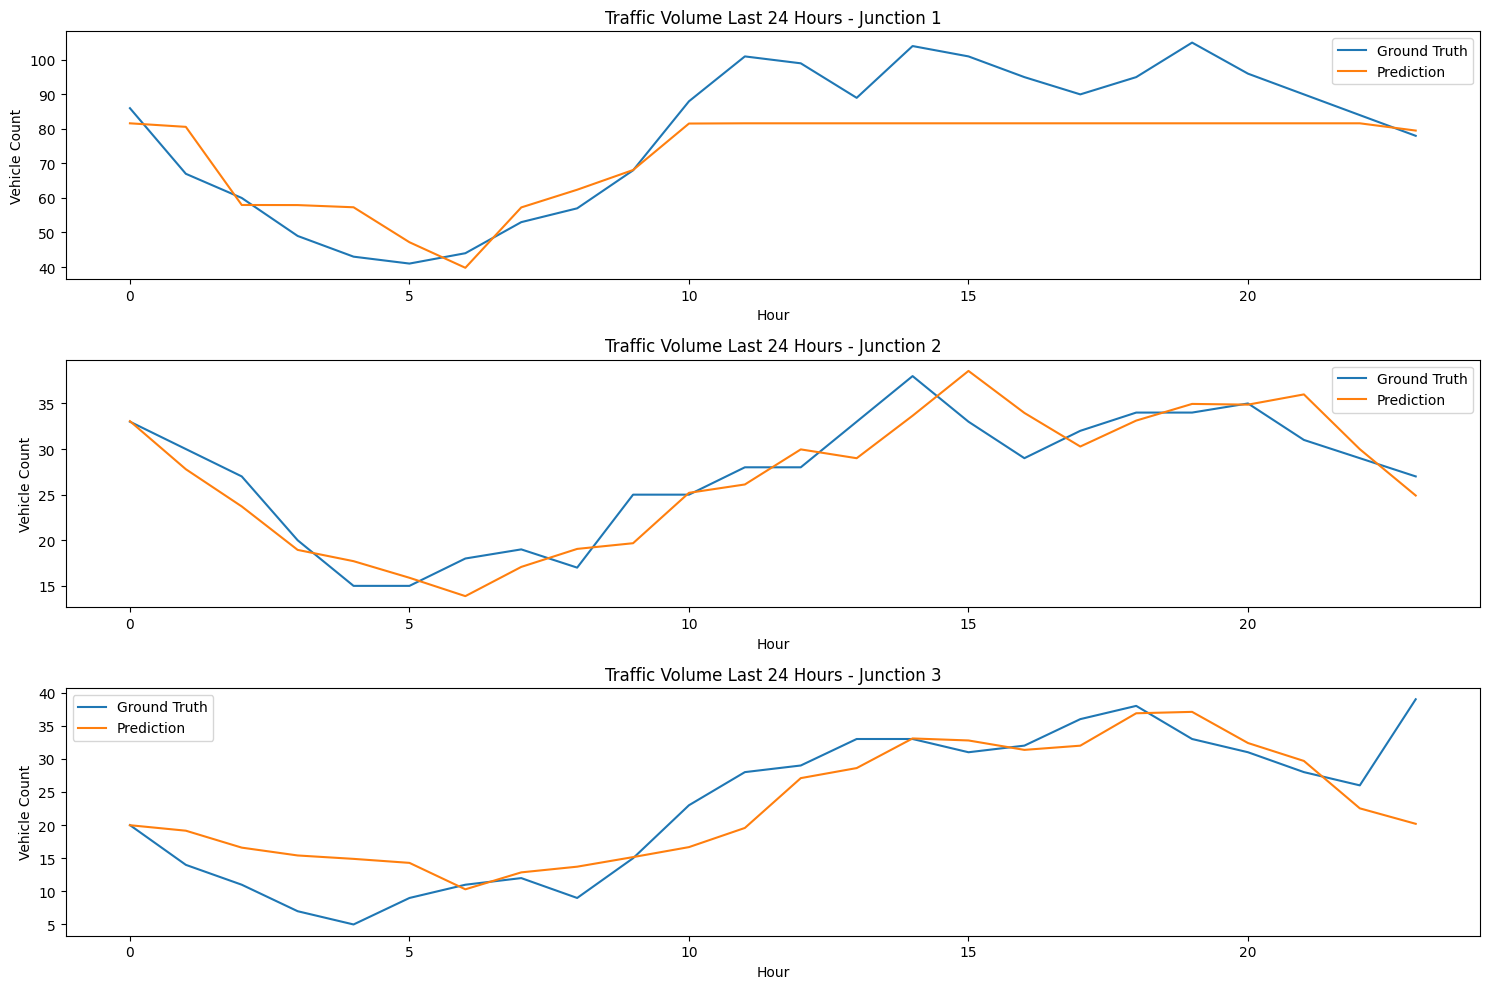

In [25]:
# --- Save predictions for last 24h (NO SCALER, RAW VALUES) ---
predictions = []
truths = []
for snapshot in list(test_dataset)[-24:]:
    x_seq = torch.tensor(snapshot.features[0], dtype=torch.float32, device=device).unsqueeze(-1)
    y_true = torch.tensor(snapshot.targets[0], dtype=torch.float32, device=device).squeeze(-1)
    y_pred = model(x_seq).squeeze(-1)
    predictions.append(np.atleast_2d(y_pred.detach().cpu().numpy()))
    truths.append(np.atleast_2d(y_true.detach().cpu().numpy()))
predictions = np.concatenate(predictions, axis=0)  # shape (24, 3)
truths = np.concatenate(truths, axis=0)            # shape (24, 3)

print("predictions shape:", predictions.shape)
print("truths shape:", truths.shape)
print("Predictions (first 5 rows):", predictions[:5])
print("Ground Truths (first 5 rows):", truths[:5])

# Plot
plt.figure(figsize=(15, 10))
for i in range(predictions.shape[1]):
    plt.subplot(predictions.shape[1], 1, i+1)
    plt.plot(np.arange(24), truths[:, i], label='Ground Truth')
    plt.plot(np.arange(24), predictions[:, i], label='Prediction')
    plt.title(f'Traffic Volume Last 24 Hours - {junctions[i]}')
    plt.xlabel('Hour')
    plt.ylabel('Vehicle Count')
    plt.legend()
plt.tight_layout()
plt.savefig('traffic_predictions_last_24h_dstgrnn.png')

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, columns=['Junction 1', 'Junction 2', 'Junction 3'])
predictions_df['Hour'] = np.arange(24)
predictions_df.to_csv('traffic_predictions_last_24h.csv', index=False)
print("Predictions for last 24 hours saved to traffic_predictions_last_24h.csv")

# RMSE, MAE, R2 for last 24h (on RAW values)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse_list = []
mae_list = []
r2_list = []
for i, name in enumerate(junctions):
    y_true = truths[:, i].reshape(-1)
    y_pred = predictions[:, i].reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    print(f"{name:<12} {rmse:10.2f} {mae:10.2f} {r2:10.2f}")

# --- Save model only ---
torch.save(model.state_dict(), 'dstgrnn_model_final.pth')
print("Model saved as dstgrnn_model_final.pth")
# --- End of script ---